# Chapter 3: 

In [2]:
# Package imports
import sklearn
from sklearn import datasets
import numpy as np
import pandas as pd

In [3]:
iris = datasets.load_iris()
X = iris.data[:,[2,3]]
y = iris.target

print(f"Class labels: {np.unique(y)}")

Class labels: [0 1 2]


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1775, stratify=y
)

In [5]:
# Check the dataset labels for class imbalance across all data
print(f"Label counts in y:{np.bincount(y)}")

Label counts in y:[50 50 50]


In [6]:
# Check label counts in training data
print(f"Label counts in y_train: {np.bincount(y_train)}")

Label counts in y_train: [35 35 35]


In [7]:
# Check label counts in test data
print(f"Label counts in y_test: {np.bincount(y_test)}")

Label counts in y_test: [15 15 15]


This seems correct as we used stratification in the sklearn train_test_split method. 

We now perform standardization by fitting the `StandardScaler` class on the training data. To prevent data leakage we use the fitted transformer on the test set without retraining. 

The `StandardScaler` standardizes features by removing the mean and scaling to unit variance:

$$z = \frac{x-\mu}{s}$$

Where $\mu$ is the mean of the training sample, s is the sample standard deviation of the standard deviation, and x is the given value. 

In [8]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)

X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

In [9]:
# Create the perceptron 
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.01, random_state=1775)
ppn.fit(X_train_scaled, y_train)

Perceptron(eta0=0.01, random_state=1775)

In [10]:
y_pred = ppn.predict(X_test_scaled)
print(f"Misclassified Examples: {(y_test != y_pred).sum()}")

Misclassified Examples: 6


In [11]:
from sklearn.metrics import accuracy_score
print(f"Accuracy score: {accuracy_score(y_pred, y_test):.3f}")

Accuracy score: 0.867


We can also use the method `.score()` which is built into all sklearn classifiers. The `score()` method computes the classification accuracy. We follow this up by plotting the decision boundary.  

In [12]:
type(ppn)

sklearn.linear_model._perceptron.Perceptron

In [13]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X:np.ndarray, y:np.ndarray, classifier:sklearn.linear_model._perceptron.Perceptron, test_idx:int=None, resolution:float=0.02):
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() -1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() -1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contour(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # Plot class examples 
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8, 
            c=colors[idx],
            marker=markers[idx],
            label=f"Class {cl}",
            edgecolor= 'black', 
        )
        
    # Highlight test examples with circles
    if test_idx:
        # Plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(
            x = X_test[:, 0], 
            y = X_test[:, 1],
            c='none', 
            edgecolor='black', 
            alpha=1.0,
            linewidth=1,
            marker='o' ,
            s=100,
            label='Test set'
                    )


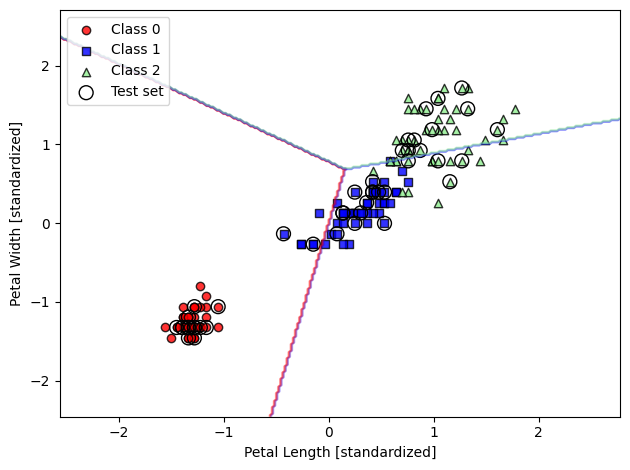

In [14]:
X_combined_scaled = np.vstack((X_train_scaled, X_test_scaled))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_scaled,
                      y=y_combined, 
                      classifier=ppn,
                      test_idx=range(105, 150))
plt.xlabel('Petal Length [standardized]')
plt.ylabel('Petal Width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Modeling Class Probabilities via logistic regression

Definitions:
---
Odds: $$\frac{p}{1-p}$$

logit: $$logit(p) = log( \frac{p}{1-p} )$$

$$logit(p) = w_1 x_1 + ... + w_m x_m + b = \sum_{i=j} \mathbf{w^Tx} + b$$

Logistic Sigmoid Function: $$\sigma(z) = \frac{1}{1 + e^{-z}},\ where\ z=\mathbf{w^Tx}+b$$

In [15]:
# Plotting the sigmoid function
def sigmoid(z:np.ndarray)-> np.ndarray:
    return 1.0 / (1.0 + np.exp(-z))

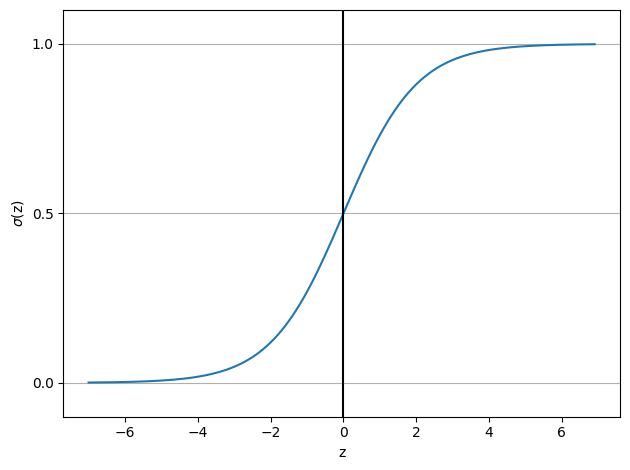

In [16]:
z = np.arange(-7, 7, 0.1)
sigma_z = sigmoid(z)
plt.plot(z, sigma_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.yticks([0.0, 0.5, 1.0])
plt.xlabel('z')
plt.ylabel('$\sigma$(z)')
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()


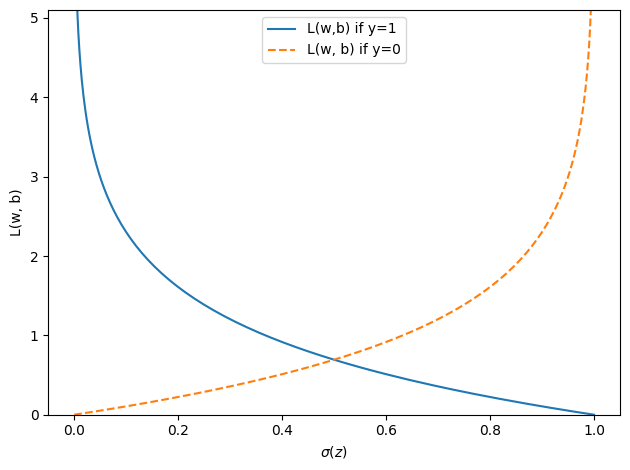

In [17]:
# Plotting the loss of classifying a single training example

def loss_1(z:np.ndarray) -> np.ndarray:
    return -np.log(sigmoid(z))

def loss_0(z:np.ndarray) -> np.ndarray:
    return -np.log(1-sigmoid(z))

z = np.arange(-10, 10, 0.1)
sigma_z = sigmoid(z)
c1 = [loss_1(x) for x in z]
plt.plot(sigma_z, c1, label="L(w,b) if y=1")
c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle='--', label="L(w, b) if y=0")
plt.ylim(0.0, 5.1)
plt.xlabel("$\sigma(z)$")
plt.ylabel("L(w, b)")
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### Converting Adaline implementation into an Algorithm for Logistic Regression

In [18]:
class LogisticRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0. )
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (-y.dot(np.log(output)) - ((1-y).dot(np.log(1- output))) / X.shape[0])
            self.losses_.append(loss)

        return self

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        return 1. / (1+ np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)


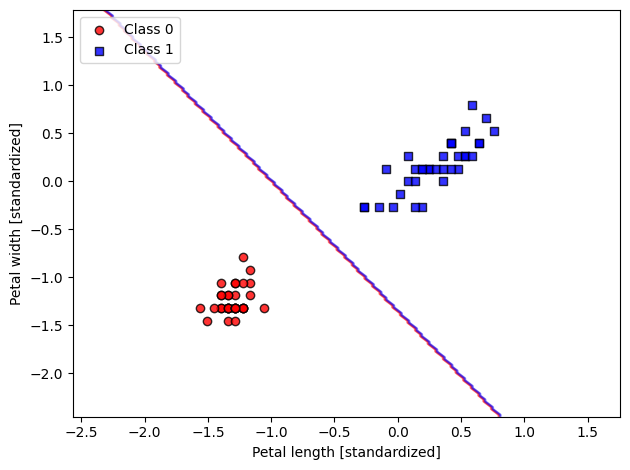

In [19]:
# Test out the logistic regression implementation
X_train_01_subset = X_train_scaled[(y_train==0) | (y_train==1)]
y_train_01_subset = y_train[(y_train==0)|(y_train==1)]
clf = LogisticRegressionGD(eta=0.3,
                           n_iter=1000,
                           random_state=1775)
clf.fit(X_train_01_subset, 
        y_train_01_subset)
plot_decision_regions(X=X_train_01_subset,
                      y=y_train_01_subset,
                      classifier=clf)
plt.xlabel("Petal length [standardized]")
plt.ylabel("Petal width [standardized]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

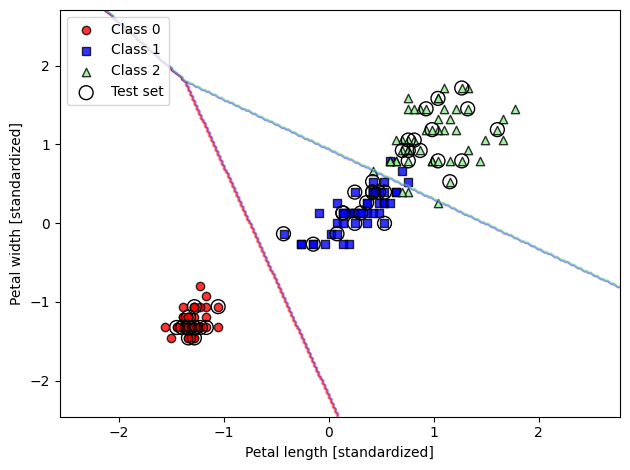

In [23]:
### Training a logistic regression model with scikit-learn

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.00, 
                        solver='lbfgs', 
                        multi_class='ovr')
lr.fit(X_combined_scaled, y_combined)
plot_decision_regions(X_combined_scaled, 
                      y_combined,
                      classifier=lr,
                      test_idx=range(105, 150))
plt.xlabel("Petal length [standardized]")
plt.ylabel("Petal width [standardized]")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

As we see above this model classifies the examples very well as the classes are linearly separable. 

In [25]:
# The probability that training examples belong to a certain class
# Row 1: class probs for first flower, Row 2: class probs for second flowers, etc.
lr.predict_proba(X_test_scaled[:3, :])

array([[8.24073343e-01, 1.75926657e-01, 2.07019121e-14],
       [8.58177168e-09, 3.57007098e-01, 6.42992893e-01],
       [8.41304278e-01, 1.58695722e-01, 1.28196526e-14]])

In [26]:
# Check that each column sums to one 
lr.predict_proba(X_test_scaled[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [27]:
# Find the most likely class for each of the three flowers
lr.predict_proba(X_test_scaled[:3, :]).argmax(axis=1)

array([0, 2, 0])

In [28]:
# We may also get the predicted class directly with the predict method
lr.predict(X_test_scaled[:3, :])

array([0, 2, 0])

### Tackling overfitting via regularization

- Models that overfit the training data are said to have high variance (notes: https://sebastianraschka.com/pdf/lecture-notes/stat451fs20/08-model-eval-1-intro__notes.pdf)
- Regularization is useful for: 
    1. Handling collinearity (high correlation among features)
    2. Filtering out noise from the data
    3. Preventing overfitting

- In regularization we introduce additional information to penalize extreme parameter (weight) values. 

- Regularization is also called L2-regularization, L2 Shrinkage, or weight decay

$$\frac{\lambda}{2n}||\mathbf{w}||^2 = \frac{\lambda}{2n}\sum_{j=1}^m w_j^2$$

Where $\lambda$ is the regularization parameter. The 2 in the denominator is a scaling factor that cancels when computing the loss gradient. The sample size n is added to scale the regularization term similar to the loss. 

Increasing the regularization of a model too much may push the weights coefficients to approach zero, causing the model to perform poorly due to underfitting. 

*Note* For regularization to work we need to ensure that all our features are on comparable scales. This is achieved by standardizing features. 

The regularized loss function: 

$$L(\mathbf{w}, b) = \frac{1}{n} \sum_{i=1}^n [-y^{(i)}log(\sigma(z^{(i)}))-(1-y^{(i)})log(1-\sigma(z^{(i)})))] + \frac{\lambda}{2n}||\mathbf{w}||^2$$

Increasing the value of $\lambda$ increases the strength of the regularization by keeping weights small. In the sklearn implementation of Logistic regression, the parameter `C` is inversely proportional the regularization, such that a small value of `C` causes high strength of regularization. 

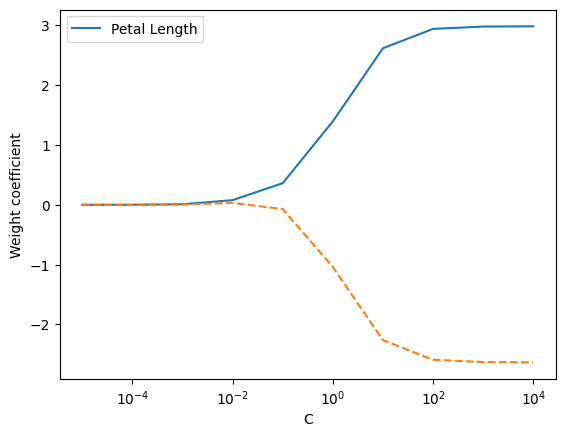

In [29]:
weights, params = [],[]
for c in np.arange(-5,5):
    lr = LogisticRegression(C=10.**c, multi_class='ovr')
    lr.fit(X_train_scaled, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
weights = np.array(weights)
plt.plot(params, 
         weights[:, 0],
         label="Petal Length"
         )
plt.plot(params, 
         weights[:, 1],
         linestyle="--")
plt.ylabel("Weight coefficient")
plt.xlabel("C")
plt.legend(loc='upper left')
plt.xscale("log")
plt.show()

## Maximum Margin Classification with Support Vector Machines

The Support Vector Machine (SVM) is considered an extension of the perceptron model.
With the perceptron model we aimed to minimize the misclassification error, in SVM we aim to maximize the margin. The SVM margin is defined as the distance between the separating hyperplane (decision boundary). The training examples that are closest to this hyperplane are the so-called *support vectors*

#### Intuition

- Decision boundaries with larger margins tend to have lower generalization error, whereas margins that are smalle are more prone to overfitting.


### Dealing with non-linearly separable cases using Slack Variables

- The **slack variable** was introduced by Vladimir Vapnik in 1995 leading to the soft-margin classification. 
- The motivation for slack variables was that the linear constraints in the SVM optimization objective need to be relaxed for nonlinearly separable data to allow the convergence of the optimization in the the presence of misclassifications, under appropriate loss penalization.  
- C is a hyperparameter for controlling penalty for misclassification. 